In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LinearRegression, Ridge, PoissonRegressor, TweedieRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score

from sklearn.model_selection import train_test_split

In [2]:
df_raw = pd.read_csv('../data/interim/preproc.csv', index_col=0)

df = df_raw[(df_raw["lines_added"]>0) & (df_raw['num_commits']<3e5) & (df_raw['lines_removed']<3e6) & (df_raw['lines_added']<3e6)].dropna()

target = 'lines_added'
#df[target] = df['num_commits']+df['lines_removed']

df.head()

key    project_id                 creation_date  \
8   EXEC-100  commons-exec  2016-01-11T16:45:23.000+0000   
10   EXEC-98  commons-exec  2016-01-08T21:40:01.000+0000   
27   EXEC-81  commons-exec  2014-02-04T04:35:59.000+0000   
28   EXEC-80  commons-exec  2014-02-01T18:38:32.000+0000   
33   EXEC-75  commons-exec  2013-12-08T11:42:40.000+0000   

                 resolution_date         type  num_commits  lines_added  \
8   2016-01-11T18:01:01.000+0000         Task            2          189   
10  2016-01-09T00:59:19.000+0000          Bug            3          345   
27  2014-04-21T23:39:27.000+0000  Improvement            2           35   
28  2014-02-04T05:20:30.000+0000          Bug            1           32   
33  2014-06-06T09:12:31.000+0000         Test            1            7   

    lines_removed  files_changed     duration  \
8             133              3     1.260556   
10            195             11     3.321667   
27             26              8  1843.057778   
28              1              3    58.699444   
33              0              1  4317.497500   

                                                 text  \
8   sync newest ant source file class copy pasta o...   
10  maven site creation fails findbugs error getti...   
27  remove remaining raw type unchecked conversion...   
28  npe map drilled problem class method checked u...   
33  test matrix update java mac o x hello might in...   

                                           inter_text  
8   sync with the newest ant source file the class...  
10  maven site creation fails with findbugs errors...  
27  remove remaining raw types unchecked conversio...  
28  npe in map  i have drilled down a problem in t...  
33  test matrix update for java 7 on mac os x  hel...

# Loading Data

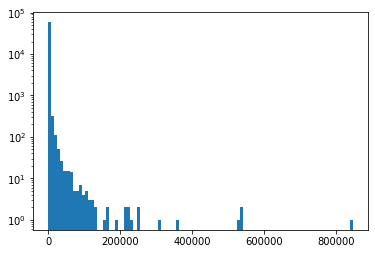

In [3]:
plt.hist(df[target], log=True, bins=100)
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.2, random_state=123)

# TF-IDF model

In [13]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
svd = TruncatedSVD(n_components=200, random_state=123)
X_train_svd = svd.fit_transform(X_train_tfidf)

X_test_tfidf = vectorizer.transform(X_test["text"])
X_test_svd = svd.transform(X_test_tfidf)

# Modeling

In [133]:
def compute_scores(model, train, test, y_train, y_test, namemodel):
    """
    Computes and prints several metrics given a model. 
    """
    y_pred = model.predict(train)
    train_abs_error = mean_absolute_error(y_train, y_pred)
    train_r2_score = r2_score(y_train, y_pred)

    y_pred = model.predict(test)
    test_abs_error = mean_absolute_error(y_test, y_pred)
    test_r2_score = r2_score(y_test, y_pred)

    print('Absolute error for '+namemodel+':')
    print('- Train:', round(train_abs_error,2))
    print('- Test:', round(test_abs_error,2))

    print('R2 score for '+namemodel+':')
    print('- Train:', round(train_r2_score,6))
    print('- Test:', round(test_r2_score,6))

## Linear Regression

In [14]:
lm = LinearRegression().fit(X_train_svd, y_train)

In [134]:
compute_scores(lm, X_train_svd, X_test_svd, y_train, y_test, 'LM')

Absolute error for LM:
- Train: 1030.35
- Test: 991.6
R2 score for LM:
- Train: 0.012583
- Test: 0.003415


## Ridge Regression

In [16]:
ridge = Ridge().fit(X_train_svd, y_train)

In [135]:
compute_scores(ridge, X_train_svd, X_test_svd, y_train, y_test, 'RIDGE')

Absolute error for RIDGE:
- Train: 1024.51
- Test: 985.54
R2 score for RIDGE:
- Train: 0.012579
- Test: 0.004017


## Gaussian Naive Bayes

In [140]:
gnb = GaussianNB().fit(X_train_svd, y_train)

In [141]:
#compute_scores(gnb, X_train_svd, X_test_svd, y_train, y_test, 'GNB')

Absolute error for GNB:
- Train: 302.71
- Test: 744.84
R2 score for GNB:
- Train: 0.991406
- Test: 0.01287


## Random Forest Regressor

In [100]:
np.random.seed(1234)
rf = RandomForestRegressor(max_depth=3, n_estimators=160, n_jobs=-1).fit(X_train_svd, y_train)

In [137]:
compute_scores(rf, X_train_svd, X_test_svd, y_train, y_test, 'RF')

Absolute error for RF:
- Train: 905.1
- Test: 890.92
R2 score for RF:
- Train: 0.167543
- Test: -0.105948


## Multi-layer Perceptron Regressor (NN)

In [130]:
mlp = MLPRegressor(max_iter=500, hidden_layer_sizes=(12,10,6), early_stopping=True).fit(X_train_svd, y_train)

In [138]:
compute_scores(mlp, X_train_svd, X_test_svd, y_train, y_test, 'MLP')

Absolute error for MLP:
- Train: 907.6
- Test: 865.28
R2 score for MLP:
- Train: 0.008523
- Test: 0.011937
